## Overview

This Kernel is based on the concept of following kernel

[Reference Kernel](https://www.kaggle.com/jotel1/nn-input-shape-why-it-matters)


## Loading required libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# plotting
import matplotlib
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler # normalization

# keras packages
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten

from keras import optimizers

# model selection and metrics
from sklearn.model_selection import train_test_split
from sklearn import metrics

# evaluation
from sklearn.metrics import confusion_matrix, accuracy_score , roc_auc_score

#
import tensorflow as tf

Using TensorFlow backend.


## keras GPU setting

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

## Loading data files

In [3]:
test_df = pd.read_csv("../input/test.csv")
train_df = pd.read_csv("../input/train.csv")
submission = pd.read_csv("../input/sample_submission.csv")

## Merging train and test data frames

In [4]:
train_df = train_df.assign(isTrain = True)
test_df = test_df.assign(isTrain=False)

full_df = pd.concat([train_df,test_df],sort=False)

## Feature scaling

In [5]:
scaler = StandardScaler()
X=scaler.fit_transform(full_df.loc[:,'var_0':'var_199'].values)

## Train, Valid data preperation

In [6]:
x = X[full_df.isTrain]
y = full_df[full_df.isTrain].target
x_test = X[~full_df.isTrain]

x_train, x_val, y_train, y_val = train_test_split(x, y , test_size=0.33, stratify=y, random_state=42)

## Reshaping data for Time Distributed Dense Layer

In [7]:
x_train = x_train.reshape(-1,200,1)
x_val = x_val.reshape(-1,200,1)
x_test = x_test.reshape(-1,200,1)

## Loss Function

In [8]:
# focal loss 
def focal_loss(alpha=0.25,gamma=5.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        alpha_t =  y_true*alpha + ((1-alpha)*(1-y_true))

        # compute the final loss and return
        return K.mean(alpha_t*K.pow((1-p_t), gamma)*bce, axis=-1)
    return focal_crossentropy

## Metric

In [9]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred,num_thresholds=50000)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

## Model Building

In [10]:
model_nn = Sequential()
model_nn.add(Dense(4, input_shape = (200,1),activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dense(16,activation='relu'))
model_nn.add(BatchNormalization())
model_nn.add(Flatten())
model_nn.add(Dense(1, activation='sigmoid'))

model_nn.compile(loss=[focal_loss(alpha=.25, gamma=2.0)], 
              optimizer='adam',
              metrics=['accuracy',auc])

model_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200, 4)            8         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 4)            16        
_________________________________________________________________
dense_2 (Dense)              (None, 200, 16)           80        
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 16)           64        
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3201      
Total params: 3,369
Trainable params: 3,329
Non-trainable params: 40
_________________________________________________________________


## Training

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=100)]

In [12]:
epochs = 200
history = model_nn.fit(x_train,
                    y_train,
                    epochs=epochs,
                    verbose=2,
                    batch_size=2048,
                    callbacks=callbacks,
                    validation_data= (x_val,y_val),
                    shuffle=True)

Train on 134000 samples, validate on 66000 samples
Epoch 1/200
 - 5s - loss: 0.0788 - acc: 0.7998 - auc: 0.6131 - val_loss: 0.0388 - val_acc: 0.8990 - val_auc: 0.7220
Epoch 2/200
 - 4s - loss: 0.0214 - acc: 0.9169 - auc: 0.7696 - val_loss: 0.0243 - val_acc: 0.9194 - val_auc: 0.7966
Epoch 3/200
 - 4s - loss: 0.0208 - acc: 0.9169 - auc: 0.8132 - val_loss: 0.0216 - val_acc: 0.9181 - val_auc: 0.8250
Epoch 4/200
 - 4s - loss: 0.0207 - acc: 0.9173 - auc: 0.8334 - val_loss: 0.0214 - val_acc: 0.9132 - val_auc: 0.8392
Epoch 5/200
 - 4s - loss: 0.0207 - acc: 0.9176 - auc: 0.8439 - val_loss: 0.0243 - val_acc: 0.9071 - val_auc: 0.8460
Epoch 6/200
 - 4s - loss: 0.0207 - acc: 0.9171 - auc: 0.8480 - val_loss: 0.0211 - val_acc: 0.9168 - val_auc: 0.8514
Epoch 7/200
 - 4s - loss: 0.0207 - acc: 0.9173 - auc: 0.8543 - val_loss: 0.0212 - val_acc: 0.9138 - val_auc: 0.8566
Epoch 8/200
 - 4s - loss: 0.0207 - acc: 0.9173 - auc: 0.8587 - val_loss: 0.0212 - val_acc: 0.9168 - val_auc: 0.8606
Epoch 9/200
 - 4s - l

## Evaluation

 Confusion metrix 
[[59130   238]
 [ 5228  1404]]
 Prediction accuracy:91.718182% Prediction auc:89.407959% Baseline accuracy:89.951515%  


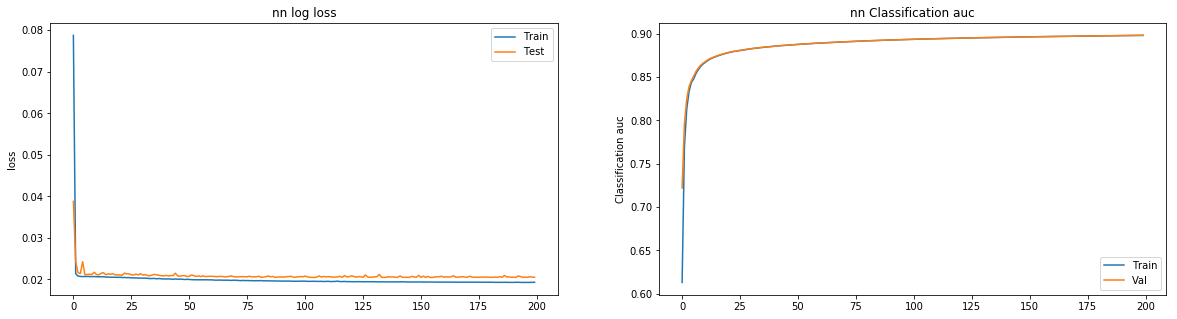

In [13]:
y_pred = model_nn.predict(x_val)
predictions = np.round(y_pred)

print(" Confusion metrix ")
print(confusion_matrix(y_val,predictions))
print(" Prediction accuracy:%2f%% Prediction auc:%2f%% Baseline accuracy:%2f%%  " %((accuracy_score(y_val,predictions)*100.00) ,roc_auc_score(y_val,y_pred)*100.00 ,((1-np.sum(y_val)/len(predictions))*100)))

x_axis = range(0,np.max(history.epoch)+1)

fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(20,5))

axes[0].plot(x_axis,history.history['loss'],label='Train')
axes[0].plot(x_axis,history.history['val_loss'],label='Test')
axes[0].legend()
axes[0].set_ylabel('loss')
axes[0].set_title('nn log loss')

# plot classificaton error
axes[1].plot(x_axis,history.history['auc'],label='Train')
axes[1].plot(x_axis,history.history['val_auc'],label='Val')
axes[1].legend()
axes[1].set_ylabel('Classification auc')
axes[1].set_title('nn Classification auc')

plt.show()

## Submission

In [14]:
submission = full_df.loc[~full_df.isTrain,['ID_code','target']]
submission['target'] = model_nn.predict(x_test)
submission.to_csv('submission.csv',index=False)